# Unsupervised Learning: Clustering Lab





In [82]:
import math
import random

from sklearn.base import BaseEstimator, ClassifierMixin, ClusterMixin
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.metrics import silhouette_score
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import io
from scipy.io import arff
import pandas as pd

from collections import Counter

In [2]:
# Utility functions
def load_data(url: str):
    ftp_stream = urllib.request.urlopen(url)
    data, meta = arff.loadarff(io.StringIO(ftp_stream.read().decode('utf-8')))
    data_frame = pd.DataFrame(data)
    return data_frame

def normalize_data(array):
    new_array = array.copy()
    _, num_cols = array.shape

    def normalize(value):
        return (value - cur_col_min) / float(cur_col_max - cur_col_min)

    for i in range(0, num_cols):
        cur_col = array[:, i]
        cur_col_max = np.max(cur_col)
        cur_col_min = np.min(cur_col)
        normalize_vectorized = np.vectorize(normalize)
        new_array[:, i] = normalize_vectorized(cur_col)
    return new_array

# Utility classes
class Point:
    def __init__(self, data):
        self.data = data

    def get_distance_to(self, point2):
        dist_squared_sum = 0
        for i in range(0, len(self.data)):
            dist_squared_sum += (pow(self.data[i] - point2.data[i], 2))
        return math.sqrt(dist_squared_sum)

## 1. Implement the HAC and K-means algorithms
For both algorithms:
- Use euclidean distance as the distance metric
- You only need to handle continuous features, but think about how you would handle nominal and unknown data
---
When reporting the results of each algorithm, include the following:
- The number of clusters (*k*)
- The silhouette score of the full clustering (You can either write and use your own silhouette_score function (extra credit) or use sklearn's)

For each cluster include:
- The vectors of points representing the cluster centroid
- The number of instances tied to that centroid
---

### 1.1 HAC (Hierarchical Agglomerative Clustering)

### HAC Code requirements 
- HAC should support both single link and complete link options.
- HAC automatically generates all clusterings from *n* to 1.  To reduce the amount of output implement a mechanism to specify for which *k* values actual output will be generated.

In [3]:
class HacCluster:
    def __init__(self, point):
        self.points = [point]

    def get_complete_link_distance(self, cluster2):
        max_distance = 0
        for i in range(0, len(self.points)):
            cluster1_point = self.points[i]
            for j in range(0, len(cluster2.points)):
                cluster2_point = cluster2.points[j]
                distance = cluster1_point.get_distance_to(cluster2_point)
                if distance > max_distance:
                    max_distance = distance
        return max_distance

    def get_single_link_distance(self, cluster2):
        min_distance = np.inf
        for i in range(0, len(self.points)):
            cluster1_point = self.points[i]
            for j in range(0, len(cluster2.points)):
                cluster2_point = cluster2.points[j]
                distance = cluster1_point.get_distance_to(cluster2_point)
                if distance < min_distance:
                    min_distance = distance
        return min_distance

    def merge(self, cluster2):
        self.points.extend(cluster2.points)

    def get_centroid(self, num_decimals=None):
        avg_point = [0] * len(self.points[0].data)
        for point in self.points:
            for j in range(0, len(self.points[0].data)):
                avg_point[j] += point.data[j]
        for i in range(0, len(avg_point)):
            avg_point[i] /= len(self.points)
            if num_decimals is not None:
                avg_point[i] = round(avg_point[i], num_decimals)
        return avg_point


class HACClustering(BaseEstimator, ClusterMixin):

    def __init__(self, k=3, link_type='single'):  ## add parameters here
        """
        Args:
            k = how many final clusters to have
            link_type = single or complete. when combining two clusters use complete link or single link
        """
        self.link_type = link_type
        self.k = k
        self.clusters = []
        self.data = []

    def fit(self, data):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.initialize_clusters(data)
        while len(self.clusters) > self.k:
            cluster_index1, cluster_index2 = self.find_nearest_clusters()
            self.merge_clusters(cluster_index1, cluster_index2)
        return self

    def print_clusters(self, num_decimals=None):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}".format(self.k))
        print("Silhouette score: {:.4f}\n".format(self.get_silhouette_score()))
        for cluster in self.clusters:
            print(cluster.get_centroid(num_decimals=num_decimals))
            print(len(cluster.points))

    def initialize_clusters(self, data):
        self.data = data
        self.clusters = []
        for row in data:
            point = Point(row)
            cluster = HacCluster(point)
            self.clusters.append(cluster)

    def find_nearest_clusters(self):
        min_distance = np.inf
        cluster_indices = (-1, -1)
        for cluster1_index in range(0, len(self.clusters)):
            for cluster2_index in range(cluster1_index + 1, len(self.clusters)):
                cluster1 = self.clusters[cluster1_index]
                cluster2 = self.clusters[cluster2_index]
                distance_between = self.get_distance(cluster1, cluster2)
                if distance_between < min_distance:
                    min_distance = distance_between
                    cluster_indices = (cluster1_index, cluster2_index)
        return cluster_indices

    def get_distance(self, cluster1, cluster2):
        if self.link_type == 'single':
            return cluster1.get_single_link_distance(cluster2)
        else:
            return cluster1.get_complete_link_distance(cluster2)

    def merge_clusters(self, cluster1_index, cluster2_index):
        cluster1 = self.clusters[cluster1_index]
        cluster2 = self.clusters[cluster2_index]
        cluster1.merge(cluster2)
        del self.clusters[cluster2_index]

    def get_silhouette_score(self):
        classified_data = []
        classifications = []
        for i, cluster in enumerate(self.clusters):
            for point in cluster.points:
                classified_data.append(point.data)
            cluster_classifications = [i] * len(cluster.points)
            classifications.extend(cluster_classifications)
        return silhouette_score(X=classified_data, labels=classifications)

### 1.1.1 (15%) Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)


---
The dataset was modified to be smaller. The last datapoint should be on line 359 or the point 0.585,0.46,0.185,0.922,0.3635,0.213,0.285,10. The remaining points are commented out.

- Include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit normalization, else you will not get the same answers as us.
- Report results for *k* = 5
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values.

---
Solutions in files:

[Debug HAC Single (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Single%20Link%20%28Silhouette%29.txt)

[Debug HAC Complete (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20HAC%20Complete%20Link%20%28Silhouette%29.txt)

In [16]:
# Debug Here
def run_single_debug():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"))
    normalized_data = normalize_data(raw_data)
    hac_clustering = HACClustering(k=5, link_type="single")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)

print("Single debug")
run_single_debug()

Single debug
Num clusters: 5
Silhouette score: 0.3453

[0.599, 0.5923, 0.4915, 0.2826, 0.2682, 0.2921, 0.2316, 0.3849]
195
[0.9189, 0.9438, 0.7105, 0.7016, 0.759, 0.7222, 0.4472, 0.8824]
1
[1.0, 0.9831, 0.8026, 0.8343, 0.6575, 0.7825, 0.9221, 0.8824]
2
[1.0, 0.9888, 0.7895, 1.0, 1.0, 0.8915, 0.7186, 0.5882]
1
[0.9189, 0.9888, 0.8684, 0.719, 0.5797, 0.7512, 0.6432, 0.9412]
1


In [17]:
def run_complete_debug():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"))
    normalized_data = normalize_data(raw_data)
    hac_clustering = HACClustering(k=5, link_type="complete")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)
print("Complete debug")
run_complete_debug()

Complete debug
Num clusters: 5
Silhouette score: 0.3095

[0.6544, 0.649, 0.5256, 0.2879, 0.2815, 0.3057, 0.2288, 0.3911]
71
[0.3661, 0.3505, 0.271, 0.1008, 0.1024, 0.1058, 0.0836, 0.2116]
67
[0.7622, 0.7658, 0.6759, 0.4265, 0.4016, 0.4536, 0.3376, 0.5217]
38
[0.8818, 0.8904, 0.7582, 0.614, 0.5433, 0.5317, 0.561, 0.7794]
16
[0.9471, 0.934, 0.8158, 0.7457, 0.6434, 0.7944, 0.6457, 0.625]
8


Discussion
My HAC algorithm consisted of the following:
1. Create an initial cluster for each point
2. While the number of clusters is greater than the target number of clusters
3. Find the two closest clusters and merge them

To implement the algorithm, I created two additional classes, a HAC cluster and a point. The point was used to abstract away finding the distances between rows in the datasets. The cluster holds a list of points and includes the functionality of merging itself with another cluster, calculating its centroid, and getting its distance to another cluster using single or complete link. I utilized sklearn's silhouette score calculator.

After running the algorithm on the debug dataset, I found that single link gives a higher silhouette score than complete link, which generally performs better at clustering strands or continuous groups rather than spherical-like groups. Single link also groups almost all the data points into a single cluster leaving single points to other clusters while complete link provides clusters with more evenly distributed points. I imagine that the data points identified in their own clusters in single link are probably outliers. When looking at the dataset description, there were a few samples taken that belonged to their own output class.

### 1.1.2 (15%) Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

#### Complete Link

In [5]:
# Load evaluation data
# Train on evaluation data using complete link
# Print clusters
def run_hac_complete_eval():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"))

    def decode(value):
        if type(value) == bytes:
            return value.decode()
        return value
    decode_vectorized = np.vectorize(decode)
    decoded_data = decode_vectorized(raw_data)
    normalized_data = normalize_data(decoded_data)
    hac_clustering = HACClustering(k=5, link_type="complete")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)

run_hac_complete_eval()

Num clusters: 5
Silhouette score: 0.2930

[0.3636, 0.4107, 0.5609, 0.3857, 0.3937, 0.2808, 0.3155, 0.0]
49
[0.3471, 0.3622, 0.7897, 0.279, 0.441, 0.8568, 0.2234, 0.0]
3
[0.1656, 0.2226, 0.3509, 0.2328, 0.152, 0.3424, 0.1918, 0.0]
18
[0.7918, 0.8268, 0.606, 0.7669, 0.7787, 0.4634, 0.7877, 1.0]
49
[0.5326, 0.6002, 0.4536, 0.5531, 0.5144, 0.5401, 0.6266, 1.0]
21


#### Single Link

In [6]:
# Load evaluation data
# Train on evaluation data using single link
# Print clusters
def run_hac_single_eval():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"))

    def decode(value):
        if type(value) == bytes:
            return value.decode()
        return value
    decode_vectorized = np.vectorize(decode)
    decoded_data = decode_vectorized(raw_data)
    normalized_data = normalize_data(decoded_data)
    hac_clustering = HACClustering(k=5, link_type="single")
    hac_clustering.fit(normalized_data)
    hac_clustering.print_clusters(num_decimals=4)

run_hac_single_eval()

Num clusters: 5
Silhouette score: 0.3971

[0.3159, 0.3648, 0.5145, 0.349, 0.3338, 0.3077, 0.2868, 0.0]
67
[0.2774, 0.2597, 1.0, 0.1224, 0.4505, 0.7549, 0.129, 0.0]
1
[0.3065, 0.3333, 0.6979, 0.2792, 0.3787, 1.0, 0.2373, 0.0]
1
[0.0884, 0.1818, 0.0, 0.145, 0.1538, 0.1245, 0.0, 0.0]
1
[0.714, 0.7588, 0.5603, 0.7028, 0.6994, 0.4864, 0.7393, 1.0]
70


Discussion
In the evaluation dataset, it looks like there are two roughly distinct spherical-like groups. Almost all the points were classified in those two groups and were roughly evenly split with a few outlier cluster classifications. The complete-link algorithm gave a better silhouette score than the single link algorithm. The single link algorithm  more evenly distributed the points among the clusters, but there were also two groups that had a higher percentage of the data points with differing output classes. I imagine that if I were to re-run the algorithm, I would achieve a higher silhouette score if only using 2 clusters and the complete link algorithm. Generally the points grouped into the output class of one had higher feature values than those with an output class of zero with the largest distance in the final feature. This makes sense when looking at the features as generally if there were more seismic bumps or energy in the previous shift, I would expect there to be more energy generally in the next shift.

### 1.2 K-means

### Code requirements 
- Ability to choose *k* and specify the *k* initial centroids
- Ability to handle distance ties--when a node or cluster has the same distance to another cluster, which should be rare, choose the earliest cluster in your list

In [7]:
class KMeansCluster:
    def __init__(self, point):
        self.points = []
        self.centroid = point
        self.previous_centroid = None

    def add_point(self, point):
        self.points.append(point)

    def clear_points(self):
        self.points = []

    def get_centroid(self, num_decimals=None):
        avg_point = [0] * len(self.points[0].data)
        for point in self.points:
            for j in range(0, len(self.points[0].data)):
                avg_point[j] += point.data[j]
        for i in range(0, len(avg_point)):
            avg_point[i] /= len(self.points)
            if num_decimals is not None:
                avg_point[i] = round(avg_point[i], num_decimals)
        return avg_point

    def set_centroid(self):
        centroid = self.get_centroid()
        self.previous_centroid = Point(self.centroid.data)
        self.centroid = Point(centroid)
        return centroid

    def check_changed(self):
        if self.previous_centroid is None:
            return True

        for i in range(0, len(self.centroid.data)):
            if self.centroid.data[i] != self.previous_centroid.data[i]:
                return True
        return False

class KMEANSClustering(BaseEstimator, ClusterMixin):

    def __init__(self, k=3, debug=False):  ## add parameters here
        """
        Args:
            k = how many final clusters to have
            debug = if debug is true use the first k instances as the initial centroids otherwise choose random points as the initial centroids.
        """
        self.k = k
        self.debug = debug
        self.clusters = []
        self.data = []
        self.raw_data = []

    def fit(self, X):
        """ Fit the data; In this lab this will make the K clusters :D
        Args:
            X (array-like): A 2D numpy array with the training data
            y (array-like): An optional argument. Clustering is usually unsupervised so you don't need labels
        Returns:
            self: this allows this to be chained, e.g. model.fit(X,y).predict(X_test)
        """
        self.initialize_points(X)
        self.initialize_clusters()
        converged = False
        while not converged:
            self.group_cluster_points()
            converged = self.check_converged()
            if not converged:
                self.reset_cluster_points()
        return self

    def initialize_points(self, X):
        self.data = []
        for row in X:
            self.data.append(Point(row))

    def initialize_clusters(self):
        self.clusters = []
        if self.debug:
            for i in range(0, self.k):
                self.clusters.append(KMeansCluster(self.data[i]))
        else:
            selection_data = self.data.copy()
            for i in range(0, self.k):
                point_index = random.randint(0, len(selection_data) - 1)
                self.clusters.append(KMeansCluster(selection_data[point_index]))
                selection_data = np.delete(selection_data, point_index, 0)

    def reset_cluster_points(self):
        for cluster in self.clusters:
            cluster.set_centroid()
            cluster.clear_points()

    def group_cluster_points(self):
        for point_index, data_point in enumerate(self.data):
            min_distance = np.inf
            min_cluster_index = -1
            for i, cluster in enumerate(self.clusters):
                distance_to_centroid = data_point.get_distance_to(cluster.centroid)
                if distance_to_centroid < min_distance:
                    min_distance = distance_to_centroid
                    min_cluster_index = i
            self.clusters[min_cluster_index].add_point(data_point)

    def check_converged(self):
        for cluster in self.clusters:
            cluster_changed = cluster.check_changed()
            if cluster_changed:
                return False
        return True

    def print_clusters(self, num_decimals=None):
        """
            Used for grading.
            print("Num clusters: {:d}\n".format(k))
            print("Silhouette score: {:.4f}\n\n".format(silhouette_score))
            for each cluster and centroid:
                print(np.array2string(centroid,precision=4,separator=","))
                print("{:d}\n".format(size of cluster))
        """
        print("Num clusters: {:d}\n".format(self.k))
        print("Silhouette score: {:.4f}\n\n".format(self.get_silhouette_score()))
        for cluster in self.clusters:
            print(cluster.get_centroid(num_decimals=num_decimals))
            print(len(cluster.points))

    def get_silhouette_score(self):
        classified_data = []
        classifications = []
        for i, cluster in enumerate(self.clusters):
            for point in cluster.points:
                classified_data.append(point.data)
            cluster_classifications = [i] * len(cluster.points)
            classifications.extend(cluster_classifications)
        return silhouette_score(X=classified_data, labels=classifications)

### 1.2.1 (10%) K-Means Debug 

Debug your model by running it on the [Debug Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff)

- Train until convergence
- Make sure to include the output class (last column) as an additional input feature
- Normalize Data--attributes should be normalized using the formula (x-xmin)/(xmax-xmin). Do this exact normalization rather than call the scikit nomralization, else you will not get the same answers as us.
- Use *k* = 5
- Use the first *k* instances in the training set as the initial centroids
- Use 4 decimal places and DO NOT ROUND when reporting silhouette score and centroid values

---
Solution in file:

[Debug K Means (Silhouette).txt](https://raw.githubusercontent.com/cs472ta/CS472/master/debug_solutions/Debug%20K%20Means%20%28Silhouette%29.txt)

In [8]:
# Load debug data
# Train on debug data
# Print clusters
def run_kmeans_debug():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/abalone.arff"))
    normalized_data = normalize_data(raw_data)
    kmeans_clustering = KMEANSClustering(k=5, debug=True)
    kmeans_clustering.fit(normalized_data)
    kmeans_clustering.print_clusters(num_decimals=4)

run_kmeans_debug()

Num clusters: 5

Silhouette score: 0.3845


[0.7325, 0.7327, 0.627, 0.3817, 0.3633, 0.4045, 0.3046, 0.4839]
75
[0.3704, 0.3519, 0.2686, 0.0926, 0.0935, 0.094, 0.0792, 0.218]
34
[0.9035, 0.905, 0.7774, 0.6579, 0.5767, 0.6193, 0.5893, 0.7279]
24
[0.5692, 0.5628, 0.4376, 0.211, 0.2113, 0.2248, 0.1659, 0.317]
54
[0.1296, 0.1037, 0.1053, 0.0177, 0.0211, 0.0272, 0.0135, 0.0724]
13


### 1.2.2 (15%) K-Means Evaluation

We will evaluate your model based on its print_clusters() output using this [Evaluation Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff) using the *same* parameters as for Debug

In [9]:
# Load evaluation data
# Train on evaluation data
# Print clusters
def run_kmeans_evaluation():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/seismic-bumps_train.arff"))

    def decode(value):
        if type(value) == bytes:
            return value.decode()
        return value
    decode_vectorized = np.vectorize(decode)
    decoded_data = decode_vectorized(raw_data)
    normalized_data = normalize_data(decoded_data)
    kmeans_clustering = KMEANSClustering(k=5, debug=True)
    kmeans_clustering.fit(normalized_data)
    kmeans_clustering.print_clusters(num_decimals=4)

run_kmeans_evaluation()

Num clusters: 5

Silhouette score: 0.2769


[0.5349, 0.6013, 0.4617, 0.5541, 0.5232, 0.5544, 0.6248, 1.0]
22
[0.3684, 0.4338, 0.4356, 0.4388, 0.3573, 0.2988, 0.3673, 0.0]
31
[0.3658, 0.3854, 0.7563, 0.3093, 0.4659, 0.3691, 0.2413, 0.0]
20
[0.1634, 0.2137, 0.3968, 0.2178, 0.1555, 0.3078, 0.1775, 0.0]
19
[0.7961, 0.831, 0.6054, 0.7709, 0.7802, 0.4553, 0.7919, 1.0]
48


## 2. Iris Clustering with Both Alogrithms
For both algorithms: 
- Don't include the output label as one of the input features
- Normalize the data
- Show your results for clusterings with *k* = 2-7.  
- Graph the silhouette score for each *k* and discuss your results (i.e. what kind of clusters are being made).
- Load this Iris Dataset [Iris Dataset](https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff)

### 2.1 (10%) Iris Clustering with HAC

- Use single-link and complete link clustering algorithms
---

Single-link HAC Clustering with k = 2
Num clusters: 2
Silhouette score: 0.6295

[0.1961, 0.5908, 0.0786, 0.06]
50
[0.545, 0.3633, 0.662, 0.6567]
100


Single-link HAC Clustering with k = 3
Num clusters: 3
Silhouette score: 0.5309

[0.199, 0.6003, 0.0792, 0.0595]
49
[0.0556, 0.125, 0.0508, 0.0833]
1
[0.545, 0.3633, 0.662, 0.6567]
100


Single-link HAC Clustering with k = 4
Num clusters: 4
Silhouette score: 0.3883

[0.199, 0.6003, 0.0792, 0.0595]
49
[0.0556, 0.125, 0.0508, 0.0833]
1
[0.5363, 0.3554, 0.6563, 0.6531]
98
[0.9722, 0.75, 0.9407, 0.8333]
2


Single-link HAC Clustering with k = 5
Num clusters: 5
Silhouette score: 0.2051

[0.199, 0.6003, 0.0792, 0.0595]
49
[0.0556, 0.125, 0.0508, 0.0833]
1
[0.5401, 0.357, 0.657, 0.6529]
97
[0.1667, 0.2083, 0.5932, 0.6667]
1
[0.9722, 0.75, 0.9407, 0.8333]
2


Single-link HAC Clustering with k = 6
Num clusters: 6
Silhouette score: 0.1605

[0.199, 0.6003, 0.0792, 0.0595]
49
[0.0556, 0.125, 0.0508, 0.0833]
1
[0.5373, 0.3537, 0.6548, 0.6493]
96
[0.16

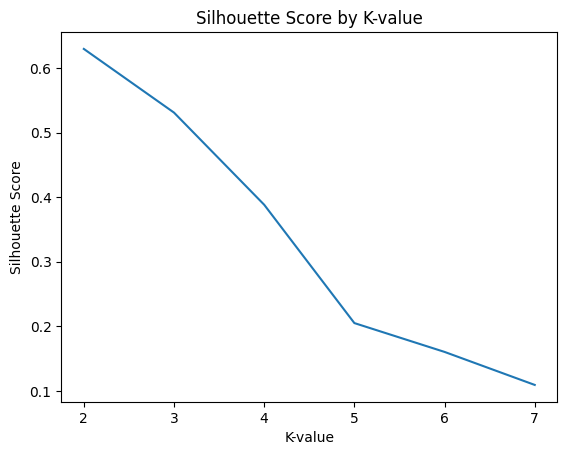

In [68]:
# Iris Clustering using single-link
def run_hac_single_iris():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = normalize_data(raw_data[:,:-1])
    k_array = [2, 3, 4, 5, 6, 7]
    silhouette_scores = []
    for i in k_array:
        print(f"Single-link HAC Clustering with k = {i}")
        hac_clustering = HACClustering(k=i, link_type="single")
        hac_clustering.fit(data)
        hac_clustering.print_clusters(num_decimals=4)
        silhouette_scores.append(hac_clustering.get_silhouette_score())
        print()
        print()
    plt.plot(k_array, silhouette_scores)
    plt.title("Silhouette Score by K-value")
    plt.xlabel("K-value")
    plt.ylabel("Silhouette Score")
    plt.show()

run_hac_single_iris()

Complete-link HAC Clustering with k = 2
Num clusters: 2
Silhouette score: 0.3039

[0.3436, 0.4318, 0.367, 0.3452]
116
[0.719, 0.4645, 0.8106, 0.8419]
34


Complete-link HAC Clustering with k = 3
Num clusters: 3
Silhouette score: 0.5031

[0.1961, 0.5908, 0.0786, 0.06]
50
[0.4554, 0.3112, 0.5855, 0.5612]
66
[0.719, 0.4645, 0.8106, 0.8419]
34


Complete-link HAC Clustering with k = 4
Num clusters: 4
Silhouette score: 0.3932

[0.2424, 0.6742, 0.0827, 0.0732]
33
[0.1062, 0.4289, 0.0708, 0.0343]
17
[0.4554, 0.3112, 0.5855, 0.5612]
66
[0.719, 0.4645, 0.8106, 0.8419]
34


Complete-link HAC Clustering with k = 5
Num clusters: 5
Silhouette score: 0.3368

[0.2424, 0.6742, 0.0827, 0.0732]
33
[0.1062, 0.4289, 0.0708, 0.0343]
17
[0.5368, 0.3671, 0.6432, 0.6295]
37
[0.3515, 0.2399, 0.512, 0.4741]
29
[0.719, 0.4645, 0.8106, 0.8419]
34


Complete-link HAC Clustering with k = 6
Num clusters: 6
Silhouette score: 0.3292

[0.2424, 0.6742, 0.0827, 0.0732]
33
[0.1062, 0.4289, 0.0708, 0.0343]
17
[0.5368, 0.36

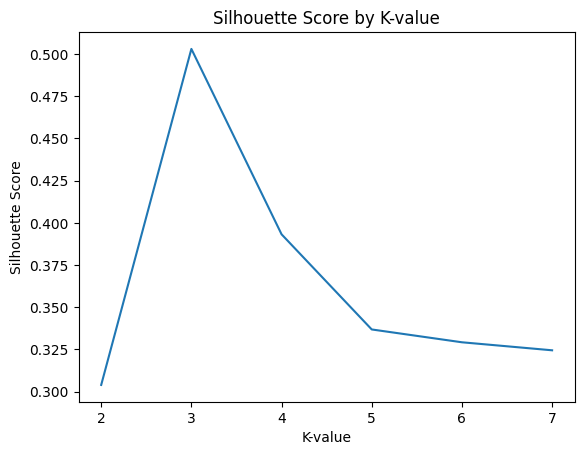

In [69]:
# Iris Clustering using complete-link
def run_hac_complete_iris():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = normalize_data(raw_data[:,:-1])
    k_array = [2, 3, 4, 5, 6, 7]
    silhouette_scores = []
    for i in k_array:
        print(f"Complete-link HAC Clustering with k = {i}")
        hac_clustering = HACClustering(k=i, link_type="complete")
        hac_clustering.fit(data)
        hac_clustering.print_clusters(num_decimals=4)
        silhouette_scores.append(hac_clustering.get_silhouette_score())
        print()
        print()
    plt.plot(k_array, silhouette_scores)
    plt.title("Silhouette Score by K-value")
    plt.xlabel("K-value")
    plt.ylabel("Silhouette Score")
    plt.show()

run_hac_complete_iris()

Discuss your results including the differences between single-link and complete-link
Initially when I ran the clustering algorithm on the data, I did so without normalizing it and single link and complete link gave somewhat similar results, but when I realized that the project specifications said to normalize the data and ran it again, I was surprised to find that complete link naturally clustered the data into 3 groups when comparing silhouette scores. Single link found the best clustering to have only two clusters while complete link identified the best clustering by silhouette score to be three clusters just as the number of output classes in the iris dataset. This seems to tell me that two species/sub-species of the iris are fairly similar while the third is quite different. This would explain how the single link clustering led to a 2-cluster optimal. However, when the clusters are examined in a more spherical manner as is done when using the complete-link metric, there seems to be more naturally three clusters. The silhouette score in both algorithms clearly demonstrates that lower numbers of clusters in clusterings are generally better than higher clusterings. This makes sense as the algorithm would be trying to subdivide the natural clusters of the three flower species.

### 2.2 (10%) Iris Clustering with K-means

KMeans Clustering with k = 2
Num clusters: 2

Silhouette score: 0.6295


[0.545, 0.3633, 0.662, 0.6567]
100
[0.1961, 0.5908, 0.0786, 0.06]
50


KMeans Clustering with k = 3
Num clusters: 3

Silhouette score: 0.4977


[0.1263, 0.3769, 0.1263, 0.0985]
22
[0.5596, 0.3733, 0.6736, 0.668]
96
[0.2439, 0.6797, 0.0842, 0.0742]
32


KMeans Clustering with k = 4
Num clusters: 4

Silhouette score: 0.4430


[0.7343, 0.4708, 0.8192, 0.8611]
30
[0.1961, 0.5908, 0.0786, 0.06]
50
[0.3457, 0.2485, 0.4997, 0.463]
27
[0.5381, 0.3605, 0.6543, 0.6357]
43


KMeans Clustering with k = 5
Num clusters: 5

Silhouette score: 0.4122


[0.1961, 0.5908, 0.0786, 0.06]
50
[0.779, 0.4801, 0.8401, 0.8623]
23
[0.3512, 0.2336, 0.5091, 0.4702]
28
[0.5233, 0.3667, 0.7139, 0.77]
25
[0.5694, 0.3993, 0.6158, 0.559]
24


KMeans Clustering with k = 6
Num clusters: 6

Silhouette score: 0.3402


[0.297, 0.7949, 0.0887, 0.0769]
13
[0.7343, 0.4708, 0.8192, 0.8611]
30
[0.2069, 0.5958, 0.0788, 0.0708]
20
[0.5381, 0.3605, 0.6543, 0.63

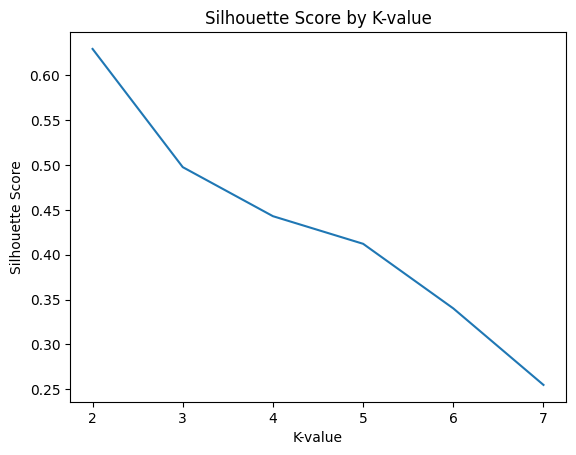

In [78]:
# Iris Clustering with K-means
def run_kmeans_iris():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = normalize_data(raw_data[:, :-1])
    k_array = [2, 3, 4, 5, 6, 7]
    silhouette_scores = []
    for i in k_array:
        print(f"KMeans Clustering with k = {i}")
        kmeans_clustering = KMEANSClustering(k=i)
        kmeans_clustering.fit(data)
        kmeans_clustering.print_clusters(num_decimals=4)
        silhouette_scores.append(kmeans_clustering.get_silhouette_score())
        print()
        print()
    plt.plot(k_array, silhouette_scores)
    plt.title("Silhouette Score by K-value")
    plt.xlabel("K-value")
    plt.ylabel("Silhouette Score")
    plt.show()

run_kmeans_iris()

Discuss your results
When running kmeans on the iris dataset, the first thing that I noticed was the high variability in silhouette scores based on the random initial centroids. Occasionally higher k-values would produce decent silhouette scores and occasionally they would produce very low silhouette scores. I hypothesize that when they give poor silhouette scores the initial centroid that was chosen was likely close to another chosen centroid which would make points around them not be very "decided" on which cluster they belonged to.
I also found it interesting that the graph of silhouette score to k-value produced was fairly similar to that of HAC single link in that the very best silhouette score was given when there were only two clusters and gradually decreased with each additional cluster. It did differ however in that with higher numbers of clusters, occasionally the silhouette score would jump higher with a different seeded centroid. I would have expected the results to be more like complete link where a k-value of three would produce the best result. I think that this just demonstrates that with the iris dataset, two types of the flowers are very similar while they are very different from the third type of flower in the dataset.

### 2.3 (5%) K-means Initial Centroids Experiment

- Run K-means 5 times with *k*=4, each time with different initial random centroids and discuss any variations in the results.
- If you ever end up with any empty clusters in K-means, re-run with different initial centroids.

In [79]:
#K-means 5 times
def run_iris_centroid_experiment():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = normalize_data(raw_data[:, :-1])
    for i in range(0, 5):
        print(f"KMeans Clustering with k = 5, iteration {i}")
        kmeans_clustering = KMEANSClustering(k=4)
        kmeans_clustering.fit(data)
        kmeans_clustering.print_clusters(num_decimals=4)
        print()
        print()

run_iris_centroid_experiment()

KMeans Clustering with k = 5, iteration 0
Num clusters: 4

Silhouette score: 0.4435


[0.1961, 0.5908, 0.0786, 0.06]
50
[0.749, 0.4769, 0.8293, 0.8673]
27
[0.5496, 0.377, 0.6626, 0.6558]
42
[0.3611, 0.246, 0.5156, 0.4745]
31


KMeans Clustering with k = 5, iteration 1
Num clusters: 4

Silhouette score: 0.3835


[0.1162, 0.4583, 0.074, 0.0379]
22
[0.2589, 0.6949, 0.0823, 0.0774]
28
[0.412, 0.2769, 0.559, 0.5208]
48
[0.6677, 0.4431, 0.7572, 0.7821]
52


KMeans Clustering with k = 5, iteration 2
Num clusters: 4

Silhouette score: 0.4435


[0.1961, 0.5908, 0.0786, 0.06]
50
[0.749, 0.4769, 0.8293, 0.8673]
27
[0.5496, 0.377, 0.6626, 0.6558]
42
[0.3611, 0.246, 0.5156, 0.4745]
31


KMeans Clustering with k = 5, iteration 3
Num clusters: 4

Silhouette score: 0.4435


[0.749, 0.4769, 0.8293, 0.8673]
27
[0.1961, 0.5908, 0.0786, 0.06]
50
[0.3611, 0.246, 0.5156, 0.4745]
31
[0.5496, 0.377, 0.6626, 0.6558]
42


KMeans Clustering with k = 5, iteration 4
Num clusters: 4

Silhouette score: 0.4446


[0.1

Discuss any variations in the results
After running the test 5 times, I found that most of the time, the clusterings gave similar silhouette scores of around .44, but it gave a silhouette score closer to .38 one time. I didn't realize how much of an impact initial centroids could have on kmeans even if non-outlier points were chosen. Each of the groupings had at least 15ish points, and in the groupings with higher silhouette scores, the groupings were a bit more evenly distributed across the groups than when the lower silhouette score appeared. In the trial that gave the lower silhouette score I also noticed that one group had significantly more points than in the other trials. I hypothesize that one of the centroids was caught in a smaller cluster of semi-outlier points while another cluster had to include more points as a result which led to more points on the border between clusters.
I also discovered that different random centroids could eventually converge to similar clusters as well, as I had a few clusterings with the same distribution. This makes sense if the initially chosen points were fairly similar to each other.

## 3. Scikit-Learn Comparison

### 3.1 (10%) Run the SK versions of HAC (just complete link) and K-means on Iris data set above

- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [86]:
# Load sklearn
def run_sklearn_iris_hac():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = normalize_data(raw_data[:, :-1])

    for i in range(2, 8):
        print(f"Complete link - n-clusters={i}")
        sklearn_hac = AgglomerativeClustering(n_clusters=i, linkage="complete")
        labels = sklearn_hac.fit_predict(data)
        print(silhouette_score(data, labels))
        print(f"Number of items in each group: {Counter(labels).values()}")
        print()
    print()

    print("Ward link - n-clusters=2")
    sklearn_hac = AgglomerativeClustering(n_clusters=2, linkage="ward")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print(f"Number of items in each group: {Counter(labels).values()}")
    print()

    print("Ward link - n-clusters=3")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, linkage="ward")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print(f"Number of items in each group: {Counter(labels).values()}")
    print()

    print("Average link - n-clusters=3")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print(f"Number of items in each group: {Counter(labels).values()}")
    print()

    print("L1 affinitiy, n-clusters=3, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, affinity='l1', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print(f"Number of items in each group: {Counter(labels).values()}")
    print()

    print("L2 affinitiy, n-clusters=3, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=3, affinity='l2', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(silhouette_score(data, labels))
    print(f"Number of items in each group: {Counter(labels).values()}")


def run_sklearn_iris_kmeans():
    raw_data = np.array(load_data(r"https://raw.githubusercontent.com/cs472ta/CS472/master/datasets/iris.arff"))
    data = normalize_data(raw_data[:, :-1])

    print("KMeans")
    for i in range(2,8):
        print(f"n-clusters={i}")
        sklearn_kmeans = KMeans(n_clusters=i, n_init=1, init="random")
        labels = sklearn_kmeans.fit_predict(data)
        print(silhouette_score(data, labels))
        print(f"Number of items in each group: {Counter(labels).values()}")
        print()
    print()

    print("n-clusters=3, number of different trial seeds=10, kmeans++ centroid initialization")
    sklearn_kmeans = KMeans(n_clusters=3)
    labels = sklearn_kmeans.fit_predict(data)
    print(silhouette_score(data, labels))
    print(f"Number of items in each group: {Counter(labels).values()}")
    print()

run_sklearn_iris_hac()
run_sklearn_iris_kmeans()

Complete link - n-clusters=2
0.30391309058110383
Number of items in each group: dict_values([116, 34])

Complete link - n-clusters=3
0.5030674466509139
Number of items in each group: dict_values([50, 66, 34])

Complete link - n-clusters=4
0.3931866272687036
Number of items in each group: dict_values([33, 17, 66, 34])

Complete link - n-clusters=5
0.3367877805272903
Number of items in each group: dict_values([33, 17, 37, 29, 34])

Complete link - n-clusters=6
0.32918681244067777
Number of items in each group: dict_values([33, 17, 37, 29, 23, 11])

Complete link - n-clusters=7
0.324436537466791
Number of items in each group: dict_values([33, 17, 23, 29, 14, 23, 11])


Ward link - n-clusters=2
0.6294675561906644
Number of items in each group: dict_values([50, 100])

Ward link - n-clusters=3
0.5043490792923953
Number of items in each group: dict_values([50, 67, 33])

Average link - n-clusters=3
0.5043490792923953
Number of items in each group: dict_values([50, 67, 33])

L1 affinitiy, n-clu

*Discuss Results and Comparison with your versions of the algorithms. Discuss effects of different hyperparameters*
The sklearn version of the algorithm gave results that appear to be the same as my results when run using complete link with different numbers of clusters. When I tweaked the link metric to be ward or average, I got similar results to those of single link in my algorithm implementation where a clustering with two clusters gave the highest silhouette score. Complete link gave the best silhouette score for a 3-cluster clustering. I also tried tweaking the affinity in the hac algorithm to use l1 and l2 metrics instead of a euclidean metric. Each of them produced silhouette scores similar to those produced when using 3 clusters and complete link. I also thought that it was interesting that in the algorithms that gave the best silhouette scores they generally grouped 50 of the flowers together in their own group. I think it would be intersting to do further investigation to see if it completely correctly identified one species of the flowers as each flower set has 50 flowers in the given dataset.

### 3.2 (10%) Run the SK version of HAC (just complete link) and K-means on a dataset of your choice 
- Report results for a couple values of *k*
- Experiment using different hyper-parameters

In [93]:
# Load sklearn
def run_sklearn_texts_hac():
    data = normalize_data(np.array(pd.read_csv("https://raw.githubusercontent.com/maclaurin36/CS472-clustering/master/AllBooks_baseline_DTM_Unlabelled.csv"))[:,:50])
    for i in range(2, 12):
        print(f"Complete link - n-clusters={i}")
        sklearn_hac = AgglomerativeClustering(n_clusters=i, linkage="complete")
        labels = sklearn_hac.fit_predict(data)
        print(f"Number of items in each group: {Counter(labels).values()}")
        print(silhouette_score(data, labels))
    print()

    print("Ward link - n-clusters=8")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, linkage="ward")
    labels = sklearn_hac.fit_predict(data)
    print(f"Number of items in each group: {Counter(labels).values()}")
    print(silhouette_score(data, labels))
    print()

    print("Average link - n-clusters=8")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(f"Number of items in each group: {Counter(labels).values()}")
    print(silhouette_score(data, labels))
    print()

    print("L1 affinitiy, n-clusters=8, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, affinity='l1', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(f"Number of items in each group: {Counter(labels).values()}")
    print(silhouette_score(data, labels))
    print()

    print("L2 affinitiy, n-clusters=8, average link")
    sklearn_hac = AgglomerativeClustering(n_clusters=8, affinity='l2', linkage="average")
    labels = sklearn_hac.fit_predict(data)
    print(f"Number of items in each group: {Counter(labels).values()}")
    print(silhouette_score(data, labels))


def run_sklearn_texts_kmeans():
    data = normalize_data(np.array(pd.read_csv(
        "https://raw.githubusercontent.com/maclaurin36/CS472-clustering/master/AllBooks_baseline_DTM_Unlabelled.csv")))
    print("KMeans")
    for i in range(2,12):
        print(f"n-clusters={i}")
        sklearn_kmeans = KMeans(n_clusters=i, n_init=1, init="random")
        labels = sklearn_kmeans.fit_predict(data)
        print(f"Number of items in each group: {Counter(labels).values()}")
        print(silhouette_score(data, labels))
    print()

    print("n-clusters=8, number of different trial seeds=10, kmeans++ centroid initialization")
    sklearn_kmeans = KMeans(n_clusters=8)
    labels = sklearn_kmeans.fit_predict(data)
    print(f"Number of items in each group: {Counter(labels).values()}")
    print(silhouette_score(data, labels))
    print()

run_sklearn_texts_hac()
run_sklearn_texts_kmeans()

Complete link - n-clusters=2
Number of items in each group: dict_values([589, 1])
0.7806663705728843
Complete link - n-clusters=3
Number of items in each group: dict_values([562, 27, 1])
0.5919413170641968
Complete link - n-clusters=4
Number of items in each group: dict_values([562, 16, 11, 1])
0.5122155019880222
Complete link - n-clusters=5
Number of items in each group: dict_values([562, 16, 4, 7, 1])
0.5172162687021529
Complete link - n-clusters=6
Number of items in each group: dict_values([562, 16, 2, 7, 2, 1])
0.5194912623299235
Complete link - n-clusters=7
Number of items in each group: dict_values([557, 16, 2, 7, 2, 5, 1])
0.5331933965384221
Complete link - n-clusters=8
Number of items in each group: dict_values([520, 16, 2, 37, 7, 2, 5, 1])
0.5803306187391004
Complete link - n-clusters=9
Number of items in each group: dict_values([508, 16, 2, 37, 12, 7, 2, 5, 1])
0.5947645463944092
Complete link - n-clusters=10
Number of items in each group: dict_values([508, 16, 2, 23, 12, 7, 

*Discussion*
I chose to use the asian religious texts dataset to see cluster sacred texts where features were collected using the bag of words technique. In this dataset there are 8 different scriptural texts, and each chapter was subdivided as a separate row in the dataset. I also decided to only use the first few features as when all features were included, the clustering algorithm grouped almost all the data points into a single clustering with single data point clusters for the remaining clusters. After reducing the input features, the clustering algorithms still found one cluster to be much more similar than all the other clusters, containing more than 90% of the data. The clustering silhouette scores show that the texts are more similar than they are different, but the silhouette scores trend upwards once we reach an 8-cluster clustering which is interesting. I'm not sure if this just occurs by chance as the number of data points in each clustering is quite low except the first clustering. I hypothesize that certain chapters between the different texts are more similar to each other than the overall texts themselves. If I were to repeat an analysis of this dataset, I would try to include chapter topics in the analysis as I think that this would provide better results. I would also be more selective of which features I gave to the model.
Another important thing that I realized when using the clustering algorithm on this dataset is that the silhouette score can be somewhat deceiving. Until I looked at the count of items in each cluster I thought that the algorithm was performing fairly well at classifying the 8 scriptural texts as the silhouette score increased when the number of clusters was increased to 8.

## 4. (Optional 5% extra credit) Write your own code for silhouette
If you do this option implement your code for silhouette above in your main implementation and use it for your experiments. Make it clear that the silhouette results come from your code. You may/should compare with the SK version to debug/verify your results.

*Discussion*
I did not implement my own silhouette scoring.